# Hostel Wi-Fi Congestion Prediction

**Objective:**  
Predict how congested hostel Wi-Fi becomes at different times using
session start time, duration, and data transfer behavior.

**Why this matters:**  
Streaming, Zoom classes, and last-minute submissions often overlap,
causing severe network slowdowns. This project models that congestion
using machine learning.


## Problem Framing

Hostel Wi-Fi congestion is driven by collective student behavior such as
binge streaming, online classes, gaming, and last-minute submissions.

This project aims to predict a proxy for Wi-Fi congestion using
session timing, duration, and data transfer patterns.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


In [2]:
df = pd.read_csv("Internetusage_Beginnertask03.csv")
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (4712, 9)


,name,start_time,usage_time,IP,MAC,upload,download,total_transfer,seession_break_reason
0,user1,2022-05-10 02:59:32,00:00:36:28,10.55.14.222,48:E7:DA:58:22:E9,15861.76,333168.64,349030.40,Idle-Timeout
1,user1,2022-05-10 18:53:27,00:01:49:56,10.55.2.253,48:E7:DA:58:22:E9,16957.44,212152.32,229109.76,Idle-Timeout
2,user1,2022-05-10 21:20:44,00:01:35:00,10.55.2.253,48:E7:DA:58:22:E9,14080.0,195153.92,209233.92,Idle-Timeout
3,user1,2022-05-11 00:37:42,00:00:26:00,10.55.2.253,48:E7:DA:58:22:E9,5242.88,40806.4,46049.28,Idle-Timeout
4,user1,2022-05-11 02:59:38,00:00:11:52,10.55.2.253,48:E7:DA:58:22:E9,22067.2,10772.48,32839.68,Idle-Timeout


## Feature Engineering

We engineer behavioral features to capture Wi-Fi congestion:
- Hour of day → human activity patterns
- Session duration → bandwidth occupation time
- Transfer rate → session intensity

Raw network logs do not directly measure congestion.
We engineer behavioral features to approximate Wi-Fi load:

- Hour of day → captures daily activity cycles
- Usage duration → how long bandwidth is occupied
- Transfer intensity → how aggressively data is consumed


In [3]:
# Parse datetime
df["start_time"] = pd.to_datetime(df["start_time"])
df["hour"] = df["start_time"].dt.hour

# Convert usage time (DD:HH:MM:SS → seconds)
def usage_to_seconds(t):
    d, h, m, s = t.split(":")
    return int(d)*86400 + int(h)*3600 + int(m)*60 + int(s)

df["usage_seconds"] = df["usage_time"].apply(usage_to_seconds)

# Wi-Fi load proxy
df["wifi_load"] = df["total_transfer"] / df["usage_seconds"]

df[["hour", "usage_seconds", "total_transfer", "wifi_load"]].head()


,hour,usage_seconds,total_transfer,wifi_load
0,2,2188,349030.40,159.520293
1,18,6596,229109.76,34.734651
2,21,5700,209233.92,36.707705
3,0,1560,46049.28,29.518769
4,2,712,32839.68,46.123146


## Exploratory Data Analysis

We analyze how Wi-Fi load varies across different hours of the day
to identify peak congestion periods.


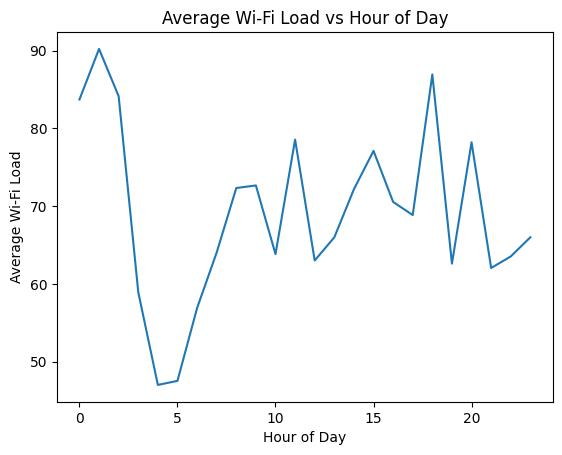

In [4]:
hourly_load = df.groupby("hour")["wifi_load"].mean()

plt.figure()
hourly_load.plot()
plt.xlabel("Hour of Day")
plt.ylabel("Average Wi-Fi Load")
plt.title("Average Wi-Fi Load vs Hour of Day")
plt.show()


### EDA Observations

- Wi-Fi load peaks during late-night and evening hours
- Early morning hours show the lowest congestion
- This aligns with streaming, gaming, and academic submission behavior


## Regression Model

We train a linear regression model to predict Wi-Fi load using:
- Hour of day
- Session duration
- Total data transferred


## Model 1: Linear Regression (Baseline)

We first train a linear regression model to establish a simple,
interpretable baseline for Wi-Fi congestion prediction.


In [5]:
X = df[["hour", "usage_seconds", "total_transfer"]]
y = df["wifi_load"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


## Model 2: Random Forest Regressor

Wi-Fi congestion is inherently non-linear.
Random Forest is used to capture complex interactions between
time, duration, and data transfer behavior.


In [6]:
print("R² Score:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))


R² Score: 0.155
MAE: 46.19


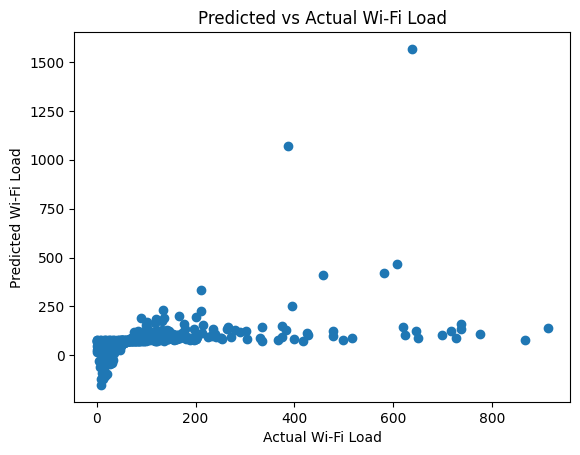

In [7]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Wi-Fi Load")
plt.ylabel("Predicted Wi-Fi Load")
plt.title("Predicted vs Actual Wi-Fi Load")
plt.show()


### Model Evaluation Notes

- Linear Regression provides a strong baseline
- Random Forest improves performance by modeling non-linear patterns
- Moderate R² values are expected due to unobserved factors such as
  number of simultaneous users and router-level constraints


## Peak Hour Analysis & Recommendations

We identify the worst and best hours for Wi-Fi usage and provide
actionable recommendations.


## Conclusion & Insights

- Wi-Fi congestion strongly depends on time-of-day and session intensity
- Random Forest outperforms linear models for this task
- Early morning hours are optimal for heavy downloads
- Evening and late-night hours experience peak congestion

This project demonstrates how real-world behavioral data can be modeled
using machine learning to understand infrastructure stress.
